# How Topic Modelling can help companies to mine through comments and reviews?

People love to leave feedbacks about the products and services in multiple channels like social media platforms, product websites, merchant websites etc. Companies have to constantly monitor user rating and comments to protect themselves. At the same time smart companies leverages these comments as sources for improvement. 
While I was trying to work on the  comments people leave from app store I wanted to see what more I can apply to user comments apart from sentimental analysis. Can I quickly sort through the comments and find out the topics people are appreciating, or dissatisfied with? Can I send only the relevant comments to relevant teams? 
 



# Topic Modelling

Topic modelling is one tools of Natural Language Processing(NLP) that helps someone to go through huge textual documents and quickly find out what the document is talking about.  The document is broken down into corpus state first and then the topic model algorithm set out to findin the probabilitis of occurance of particular words in particular topics. For example "dog" and "bone" will appear more frequency in a document about dogs. The document may also be talking about cats, but we can assume that in a document about dogs there would probably 9 times more dog words than cat words. Topic modellign help to capture this. More can read in https://en.wikipedia.org/wiki/Topic_model 


#### Import packages

In [2]:
# @hidden_cell

# packages to store and manipulate data
import pandas as pd
import numpy as np

# plotting packages
import matplotlib.pyplot as plt
%matplotlib inline

# package to clean text
import re

# I am going to use Genisis package for the modelling. 
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# nltk
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# package to print
from pprint import pprint

# settings to display
pd.set_option("display.max_columns", None)
pd.options.display.max_colwidth = 50


import warnings; 
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 




---------------
#### Data Background

All banks provide their customers banking experience through the Mobile apps. For the new gen banking customers a smooth mobile banking experience is a must have. For this project I am going to use the Apple app store reviews left for the net banking mobile app of a leading Indian bank. I extracted 1000 reviews using 'app_store_scraper' package and filtered for reviews with less than 4 rating, i.e negative reviews, for analysis. 

------

### Let's look at the data

In [4]:
# Read the review data
review_df = pd.read_csv("https://raw.githubusercontent.com/rollyjohn/Topic-Modelling/main/reviews_appstore_for_topicmodelling.csv")

print(review_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  1000 non-null   object
 1   rating  1000 non-null   int64 
 2   date    1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB
None


The data set contains 1000 reviews. Lets look the data closely

In [5]:
# @hidden_cell
# Print
pd.options.display.max_colwidth = 100
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

display(review_df.head())

,review,rating,date
0,The deletion option does not allow the account holder to select more thank one payee account for...,5,31/12/21 9:34
1,Same issue repeats - credit card tab not working especially for Sapphiro Amex cards. I can not ‘...,2,05/04/21 12:14
2,1. The app could do with a serious makeover also ensuring that all the functionality still works...,1,01/01/22 3:31
3,Hello...all other banks like sbi RBL etc have provided the facility to directly pay their credit...,1,27/12/18 15:37
4,The update has a great new User Interface. Love the new Analytics feature called “Discover” int...,5,24/12/18 9:26


------------------


The first impression is that people leave feedbacks on multuple topics in the same entry. This will make it difficult to narrow down on the key topic of each review. 

To make life bit easy I select reviews with rating below 4 , basically negative rating, for further analysis. I can assume that this set of comments are complaints and topics coming our from analysis are that which need improvement. 

------------------

In [6]:
# Filter te negative reviews
neg_review_df = review_df.loc[review_df['rating'] < 4]
neg_review_df.reset_index(drop=True, inplace=True)
print(neg_review_df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  450 non-null    object
 1   rating  450 non-null    int64 
 2   date    450 non-null    object
dtypes: int64(1), object(2)
memory usage: 10.7+ KB
None


---------------------------------------------------------------------------------------
After filtering we have 450 reviews in our dataframe now. 



Lets look the the top reviews in the dataset

In [7]:
pd.options.display.max_colwidth = 120

display(neg_review_df.head())


,review,rating,date
0,Same issue repeats - credit card tab not working especially for Sapphiro Amex cards. I can not ‘manage’ Amex cards a...,2,05/04/21 12:14
1,1. The app could do with a serious makeover also ensuring that all the functionality still works. Like never have I ...,1,01/01/22 3:31
2,Hello...all other banks like sbi RBL etc have provided the facility to directly pay their credit card bills via thei...,1,27/12/18 15:37
3,I like to set limits for all transactions just because I do not get overboard with spends. Before the previous updat...,1,17/10/21 22:54
4,"To whom ever it concern, I had downloaded app and I have been trying to login through registered mobile number and...",1,04/07/20 12:40


------------------

If I were to manually inspect the comments it will look like this,

0. Improvement suggestion on multiple topics -  credit card tab, FasTag display on app, better interface for debit card block, NPS tab, investment tab. 

1. User complaint on multiple topics - overall makeover, spammy advertisements on login, customer care calls.

2. User is asking for new feature -  a direct credit card payment to any bank.

3. User is not able to set the transaction limit.

4. User is not able to login through registered mobile.



Let's try topic modelling to achieve the same result in must faster way. The first step for modelling is pre-processing the data


------------------



## Data preprocessing

Data for modelling is preprared after processing with below steps

- Tokenization
- Remove stop words
- Lemmatization

In [8]:
# @hidden_cell
# First tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

neg_review_df['data_words'] = list(sent_to_words(neg_review_df.review))

# After tokenization remove stoword and apply lemmatization 
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['app', 'bank', 'account','try','issue','problem', 'face'])  #adding my own stop words

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):

    # remove stop words
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts_out = []

    # Lemmatization
    nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

neg_review_df['data_ready'] = process_words(neg_review_df.data_words)  # processed Text Data!

Our data is ready for model fit now. 

---------------

## Latent Dirichlet allocation (LDA)

LDA is the most commonly used algorithm in Topic Modelling , developed by David Blei, Andrew Ng, and Michael I. Jordan in 2002.  It builds a topic-per-document model and words-per-topic model, modelled as Dirichlet distributions. As the words 'latent' suggests LDA sets to discover the hidden pattern that is yet to be discovered.


#### Parameters of LDA
- Number of Topics – Number of topics to be extracted from the corpus. There are advanced approaches like Kullback Leibler Divergence to obtain the optimal number of topics.

- Number of Topic Terms – Number of terms composed in a single topic. It is generally decided according to the requirement. If the problem statement talks about extracting themes or concepts, it is recommended to choose a higher number, if problem statement talks about extracting features or terms, a low number is recommended.

- Number of Iterations / passes – Maximum number of iterations allowed to LDA algorithm for convergence.

One can learm more about LDA paramters here https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/ 


----------

In [9]:

# The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus
# Create the Dictionary and Corpus needed for Topic Modelling


#  Dictionary
id2word = corpora.Dictionary(neg_review_df.data_ready)

#  Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in neg_review_df.data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= 8,     # decided to start with 8 topics. There are advanced approaches like Kullback Leibler Divergence 
                                                              # to obtain the optimal number of topics.                          
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,  
                                           passes=10,   
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

# Look at the topics and key words
pprint(lda_model.print_topics())

[(0,
  '0.051*"update" + 0.038*"go" + 0.034*"pay" + 0.031*"bill" + '
  '0.031*"statement" + 0.029*"click" + 0.028*"unable" + 0.027*"add" + '
  '0.027*"bug" + 0.025*"due"'),
 (1,
  '0.062*"card" + 0.039*"credit" + 0.032*"work" + 0.032*"show" + 0.026*"use" + '
  '0.025*"even" + 0.022*"get" + 0.021*"time" + 0.020*"check" + 0.019*"detail"'),
 (2,
  '0.052*"update" + 0.039*"crash" + 0.038*"mobile" + 0.033*"well" + '
  '0.027*"change" + 0.023*"send" + 0.019*"verify" + 0.019*"team" + '
  '0.018*"great" + 0.015*"connection"'),
 (3,
  '0.091*"screen" + 0.041*"home" + 0.035*"balance" + 0.028*"block" + '
  '0.025*"look" + 0.024*"see" + 0.020*"soon" + 0.017*"section" + '
  '0.017*"navigate" + 0.017*"user"'),
 (4,
  '0.097*"customer" + 0.057*"service" + 0.040*"open" + 0.030*"say" + '
  '0.029*"care" + 0.025*"week" + 0.023*"ever" + 0.020*"number" + '
  '0.020*"feedback" + 0.020*"money"'),
 (5,
  '0.057*"error" + 0.045*"message" + 0.031*"loan" + 0.026*"server" + '
  '0.025*"developer" + 0.024*"downlo

-------

How to interpret the output?

The model has given 8 topics. Each topic is a weighted combination of words.  

For 'Topic 1' , the maximum weightage is for 'card' followed by 'credit',  indicating the topic covers issues related to credit card.

--------

#### Perplexity & Coherence

Perplexity measures how surprised the trained model will be if we introduce a new data to the training bunch. Lower the score the better. Coherence score measures the semantic similarity between the keywords within a topic. A score above 0.55 can be considered as 'okay enough'. 

In [10]:
# @hidden_cell
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=neg_review_df.data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.309259058077619

Coherence Score:  0.34432870000081944


------

The coherence score needs improvement which can be achived by two ways
1. topic model selection through 'elbow method'
2. parameter tuning

I am not covering  in this blog. 

------

## Visualize the topics-keywords


Before visualizing lets look at the Topic and Keys words once again, but in better format

In [11]:
for idx, topic in lda_model.show_topics(formatted=False, num_words= 15):
    print('Topic: {} --> Words: {}'.format(idx, '/'.join([w[0] for w in topic])))

Topic: 0 --> Words: update/go/pay/bill/statement/click/unable/add/bug/due/page/last/want/get/back
Topic: 1 --> Words: card/credit/work/show/use/even/get/time/check/detail/transaction/option/make/iphone/feature
Topic: 2 --> Words: update/crash/mobile/well/change/send/verify/team/great/connection/still/network/reinstall/sm/number
Topic: 3 --> Words: screen/home/balance/block/look/see/soon/section/navigate/user/button/tab/hang/value/performance
Topic: 4 --> Words: customer/service/open/say/care/week/ever/number/feedback/money/connect/request/give/link/month
Topic: 5 --> Words: error/message/loan/server/developer/download/say/offer/several/respond/continuously/tap/ui/irritate/technical
Topic: 6 --> Words: login/time/ask/application/open/give/pin/go/option/touch/enter/back/instal/allow/notification
Topic: 7 --> Words: people/recharge/year/receive/loot/charge/ticket/call/feel/scam/refund/permanently/automatically/believe/type


---------------------------------------------------------------------------------------

Now we can see the Topics and Keys words neatly arranged

---------------------------------------------------------------------------------------

###  Visual exploration: What are the dominant topics and key words?

The first analysis I am interested to see is the most discussed topics from all reviews. What is the key issue users are facing? 

I calculate,

1.	dominant topic per review

2.	weightage of dominant topic per review




In [12]:
# Calculate the topic distribution

from matplotlib.ticker import FuncFormatter

# Dominant topic in each review
def topics_per_review(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_review(model=lda_model, corpus=corpus, end=-1)            


Code to find count of topics in the dataset

In [13]:

# Distribution of Dominant Topics in Each review
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
#print(df)
dominant_topic_in_each_rev = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_rev = dominant_topic_in_each_rev.to_frame(name='count').reset_index()
display(df_dominant_topic_in_each_rev)

,Dominant_Topic,count
0,0,34
1,1,250
2,2,37
3,3,16
4,4,35
5,5,18
6,6,54
7,7,5


- 'Topic 1' is the dominant topic for 250 reviews

In [14]:
# @hidden_cell
# Total Topic Distribution by actual weight
topic_weightage_by_rev = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_rev = topic_weightage_by_rev.sum().to_frame(name='count').reset_index()

display(df_topic_weightage_by_rev)

,index,count
0,0,51.185
1,1,151.635
2,3,31.796
3,4,44.544
4,5,29.943
5,6,62.665
6,2,56.414
7,7,15.256




Now we can create plots to visualize the data



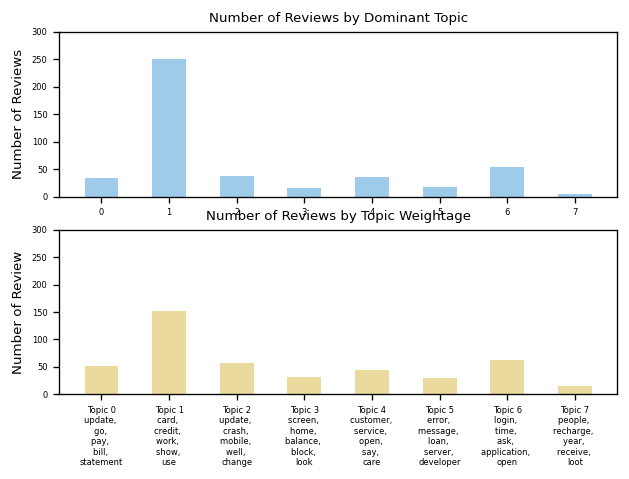

In [15]:
# @hidden_cell
# Plots 
from matplotlib.ticker import FuncFormatter

# Top  Keywords for each Topic
topic_top_n_words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 5]  # for 5 key words

df_top_n_words_stacked = pd.DataFrame(topic_top_n_words, columns=['topic_id', 'words'])
df_top_n_words = df_top_n_words_stacked.groupby('topic_id').agg(', \n'.join)
df_top_n_words.reset_index(level=0,inplace=True)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_rev, width=.5, color='#9ECBEA')
ax1.set_xticks(range(df_dominant_topic_in_each_rev.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top_n_words.loc[df_top_n_words.topic_id==x, 'words'].values[0])
# ax1.xaxis.set_major_formatter(tick_formatter)
ax1.tick_params(labelsize=5)
ax1.set_title('Number of Reviews by Dominant Topic', fontdict=dict(size=8))
ax1.set_ylabel('Number of Reviews', fontsize = 8)
ax1.set_ylim(0, 300)


# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_rev, width=.5, color='#EADA9E')
ax2.set_xticks(range(df_topic_weightage_by_rev.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.tick_params(labelsize=5)
ax2.set_title('Number of Reviews by Topic Weightage', fontdict=dict(size=8))
ax2.set_ylabel('Number of Review', fontsize = 8)

plt.show()


-------

'Topic 1' has maximum number of reviews and weightage followed by 'Topic 6'

•	'Topic 1' has top key words as 'card', and 'credit' which are pointing towards issues related to credit (or any card) functionalities

•	'Topic 6' consists of words like 'login', 'time', 'application' etc which indicates that topic is talking about issues related to account login experience

--------


### Classifying each feedback to a dominant topic

Another important step is to assign topic to each feedback in our data set. This is done by calculating % contribution of topics to feedback, like below:

In [16]:
# @hidden_cell
def format_topics_sentences(ldamodel=None, corpus=corpus, texts= neg_review_df.review):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document

    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    contents.reset_index(drop=True, inplace=True)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=neg_review_df.review)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'review']
display(df_dominant_topic.head(5))

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,review
0,0,1.0,0.432,"card, credit, work, show, use, even, get, time, check, detail",Same issue repeats - credit card tab not working especially for Sapphiro Amex cards. I can not ‘manage’ Amex cards a...
1,1,1.0,0.491,"card, credit, work, show, use, even, get, time, check, detail",1. The app could do with a serious makeover also ensuring that all the functionality still works. Like never have I ...
2,2,1.0,0.688,"card, credit, work, show, use, even, get, time, check, detail",Hello...all other banks like sbi RBL etc have provided the facility to directly pay their credit card bills via thei...
3,3,0.0,0.769,"update, go, pay, bill, statement, click, unable, add, bug, due",I like to set limits for all transactions just because I do not get overboard with spends. Before the previous updat...
4,4,2.0,0.568,"update, crash, mobile, well, change, send, verify, team, great, connection","To whom ever it concern, I had downloaded app and I have been trying to login through registered mobile number and..."


--------

Now I can compare manual analysis did in the beginning with what model is suggesting. 

•	first and third reviews have mentioned issues pertaining to credit card features provided in the app, model has correctly assigned ‘topic 1’ here .

•	fourth review is about spending limit, model assigned ‘topic 0’ which has keys words like bill, statement, update

•	same way fifth review is about login issues for which 'topic 2' is an appropriate match. 

•	Only mismatch I feel is on second review which is talking about overall look and feel of the app. So ‘topic 1’ looks to be wrong here. 

Overall the model worked well! Once the topics and key words are identifies the relevant feedbacks can be routed to respective teams whether product owner or app engineer or marketing head. 


-----------







## Conclusion

Topic modelling helps to discover the patterns and topics from huge amount of text data in an efficient way.  There are many practical applications of such a tool to companies, like

•	Automatic routing of topics & reviews to relevant teams (strategy, product owner, application maintenance) for further action

•	Automation of the data mining

•	Decision automation

#### References:

•	Blei, David M.; Ng, Andrew Y.; Jordan, Michael I; Lafferty, John (January 2003). "Latent Dirichlet allocation". Journal of Machine Learning Research.

•	https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ 

•	https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/ 




